# Modeling Usage Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from vtt.data.caption_preprocessing import load_tokenizer
from vtt.data.image_preprocessing import load_features
from vtt.data.data_loader import load_features_and_sequences, prepare_training_dataset
from vtt.models.decoder import build_decoder_model
from vtt.models.train import train_model
from vtt.models.predict import display_images_with_captions

2025-07-15 09:34:39.192475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 09:34:39.203247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752586479.217797  179946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752586479.221443  179946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752586479.232252  179946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Load Processed Data

In [3]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.pkl"

features_npz = np.load(features_path)
captions_npz = np.load(captions_path, allow_pickle=True)
tokenizer = load_tokenizer(tokenizer_path)

# Load the raw (feature, caption) dataset
raw_dataset = load_features_and_sequences(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=32,
    shuffle=True,
)

[INFO] Tokenizer loaded from pickle file: ../data/processed/flickr8k_tokenizer.pkl


2025-07-15 09:35:28.841441: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Prepare and Batch Training Dataset

In [4]:
# Prepare the dataset for seq2seq training (input/target split)
training_dataset = prepare_training_dataset(raw_dataset)

# Apply batching and prefetching safely
batched_dataset = training_dataset.batch(64, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

## Build Model

In [5]:
# Get max caption length from dataset
for (_, caption_input), _ in batched_dataset.take(1):
    max_caption_len = caption_input.shape[1]

# Get vocab size from tokenizer
vocab_size = tokenizer.num_words

model = build_decoder_model(vocab_size=vocab_size, max_caption_len=max_caption_len)
model.summary()

2025-07-15 09:35:32.853801: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "ImageCaptionDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_image        │ (None, 1, 256)    │          0 │ image_dense[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_image_caption │ (None, 19, 256)   │          0 │ expand_image[0][… │
│ (Concatenate)       │                   │            │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ merge_image_capt… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trim_image_output   │ (None, 18, 10000) │          0 │ output_dense[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [6]:
# # Clear session to prevent tf graph tracing error
# tf.keras.backend.clear_session()

# Train model
history = train_model(
    dataset=batched_dataset,
    model=model,
    epochs=5,
    checkpoint_path="../models/flickr8k_decoder_weights.weights.h5"
)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 3.5115
Epoch 1: loss improved from inf to 2.83163, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 304s 510ms/step - loss: 3.5104
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 2.2201
Epoch 2: loss improved from 2.83163 to 2.16304, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 325s 548ms/step - loss: 2.2200
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 2.0354
Epoch 3: loss improved from 2.16304 to 1.99869, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 315s 531ms/step - loss: 2.0354
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 1.9201
Epoch 4: loss improved from 1.99869 to 1.89072, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 320s 540ms/step - loss: 1.9200
Epoch 5/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step

## Predict Sample Captions

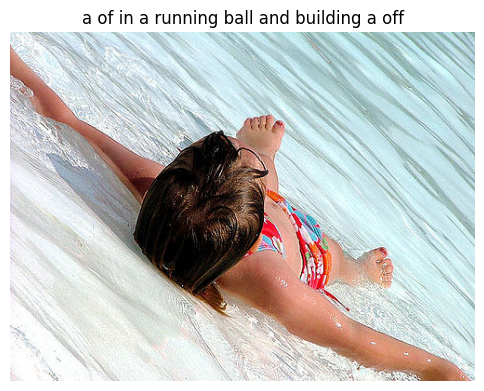

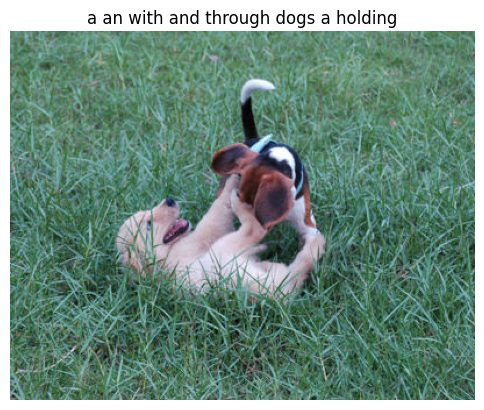

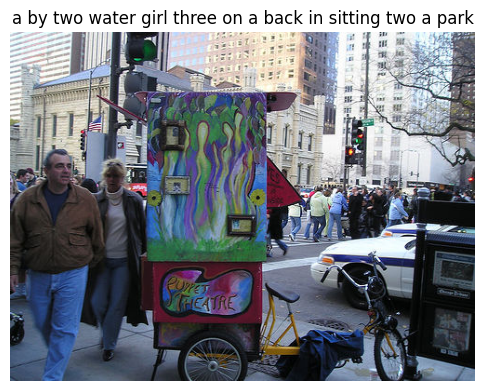

In [7]:
# Update this path to your local copy of the images
image_folder = f"../../data/flickr8k_images/subset"

sample_image_ids = [
    "667626_18933d713e.jpg",
    "23445819_3a458716c1.jpg",
    "27782020_4dab210360.jpg"
]

display_images_with_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features_npz,
    image_folder=image_folder
)